The examples below are simply a copy of collection from [Dask Example Notebooks](https://github.com/dask/dask-examples).

# Dask Arrays

<img src="https://github.com/dask/dask-examples/blob/main/images/dask-array-black-text.svg?raw=1" 
     align="right"
     alt="Dask arrays are blocked numpy arrays">
     
Dask arrays coordinate many Numpy arrays, arranged into chunks within a grid.  They support a large subset of the Numpy API.

## Create Random array

This creates a 10000x10000 array of random numbers, represented as many numpy arrays of size 1000x1000 (or smaller if the array cannot be divided evenly). In this case there are 100 (10x10) numpy arrays of size 1000x1000.

In [ ]:
import dask.array as da
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Use NumPy syntax as usual

In [ ]:
y = x + x.T
z = y[::2, 5000:].mean(axis=1)
z

dask.array<mean_agg-aggregate, shape=(5000,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

Call `.compute()` when you want your result as a NumPy array.

If you started `Client()` above then you may want to watch the status page during computation.

In [ ]:
z.compute()

array([1.00413404, 0.99103956, 0.99901037, ..., 0.99805427, 0.99316636,
       1.00018507])

## Persist data in memory

If you have the available RAM for your dataset then you can persist data in memory.  

This allows future computations to be much faster.

In [ ]:
y = y.persist()

In [ ]:
%time y[0, 0].compute()

CPU times: user 1.87 ms, sys: 0 ns, total: 1.87 ms
Wall time: 1.62 ms


0.932016189932539

In [ ]:
%time y.sum().compute()

CPU times: user 128 ms, sys: 3.55 ms, total: 132 ms
Wall time: 92.1 ms


100004647.48492943

# Dask DataFrames



<img src="https://github.com/dask/dask-examples/blob/main/images/dask-dataframe.svg?raw=1" 
     align="right"
     width="30%"
     alt="Dask dataframes are blocked Pandas dataframes">
Dask Dataframes coordinate many Pandas dataframes, partitioned along an index.  They support a large subset of the Pandas API.
     


In [ ]:
! pip install "dask[dataframe]"

     |████████████████████████████████| 112kB 13.0MB/s 


## Create Random Dataframe

We create a random timeseries of data with the following attributes:

1.  It stores a record for every 10 seconds of the year 2000
2.  It splits that year by month, keeping every month as a separate Pandas dataframe
3.  Along with a datetime index it has columns for names, ids, and numeric values

This is a small dataset of about 240 MB. Increase the number of days or reduce the frequency to practice with a larger dataset. See [doc](https://docs.dask.org/en/latest/api.html#dask.datasets.timeseries) for details.

In [ ]:
import dask
import dask.dataframe as dd

"""
def timeseries(
    start="2000-01-01",
    end="2000-01-31",
    freq="1s",
    partition_freq="1d",
    dtypes={"name": str, "id": int, "x": float, "y": float},
    seed=None,
    **kwargs
)

Create timeseries dataframe with random data

Parameters
----------
start : datetime (or datetime-like string)
    Start of time series
end : datetime (or datetime-like string)
    End of time series
dtypes : dict
    Mapping of column names to types.
    Valid types include {float, int, str, 'category'}
freq : string
    String like '2s' or '1H' or '12W' for the time series frequency
partition_freq : string
    String like '1M' or '2Y' to divide the dataframe into partitions
seed : int (optional)
    Randomstate seed
kwargs:
    Keywords to pass down to individual column creation functions.
    Keywords should be prefixed by the column name and then an underscore.

Examples
--------
>>> import dask
>>> df = dask.datasets.timeseries()
>>> df.head()  # doctest: +SKIP
            timestamp    id     name         x         y
2000-01-01 00:00:00   967    Jerry -0.031348 -0.040633
2000-01-01 00:00:01  1066  Michael -0.262136  0.307107
2000-01-01 00:00:02   988    Wendy -0.526331  0.128641
2000-01-01 00:00:03  1016   Yvonne  0.620456  0.767270
2000-01-01 00:00:04   998   Ursula  0.684902 -0.463278
>>> df = dask.datasets.timeseries(
...     '2000', '2010',
...     freq='2H', partition_freq='1D', seed=1,  # data frequency
...     dtypes={'value': float, 'name': str, 'id': int},  # data types
...     id_lam=1000  # control number of items in id column
... )
"""
df = dask.datasets.timeseries()

Unlike Pandas, Dask DataFrames are lazy and so no data is printed here.

In [ ]:
df

,id,name,x,y
npartitions=30,,,,
2000-01-01,int64,object,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


But the column names and dtypes are known.

In [ ]:
df.dtypes

id        int64
name     object
x       float64
y       float64
dtype: object

Some operations will automatically display the data.

In [ ]:
import pandas as pd
pd.options.display.precision = 2
pd.options.display.max_rows = 10

In [ ]:
df.head(3)

,id,name,x,y
timestamp,,,,
2000-01-01 00:00:00,997,Dan,0.62,-0.08
2000-01-01 00:00:01,1051,Ray,0.25,-0.29
2000-01-01 00:00:02,1035,Xavier,0.87,0.73


## Use Standard Pandas Operations

Most common Pandas operations operate identically on Dask dataframes

In [ ]:
df2 = df[df.y > 0]
df3 = df2.groupby('name').x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 157 tasks

Call `.compute()` when you want your result as a Pandas dataframe.

If you started `Client()` above then you may want to watch the status page during computation.

In [ ]:
computed_df = df3.compute()
type(computed_df)

pandas.core.series.Series

In [ ]:
computed_df

name
Alice      0.58
Bob        0.58
Charlie    0.58
Dan        0.58
Edith      0.58
           ... 
Victor     0.58
Wendy      0.58
Xavier     0.58
Yvonne     0.58
Zelda      0.58
Name: x, Length: 26, dtype: float64

## Persist data in memory

If you have the available RAM for your dataset then you can persist data in memory.  

This allows future computations to be much faster.

In [ ]:
df = df.persist()

## Time Series Operations

Because we have a datetime index time-series operations work efficiently

In [ ]:
%matplotlib inline

In [ ]:
df[['x', 'y']].resample('1h').mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,-4.35e-04,-5.15e-04
2000-01-01 01:00:00,-1.69e-02,-8.23e-04
2000-01-01 02:00:00,1.28e-02,-4.30e-03
2000-01-01 03:00:00,1.91e-02,-2.81e-03
2000-01-01 04:00:00,-7.35e-03,-8.83e-03


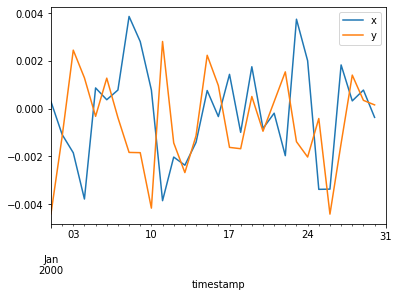

In [ ]:
df[['x', 'y']].resample('24h').mean().compute().plot()

In [ ]:
df[['x', 'y']].rolling(window='24h').mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,0.62,-0.08
2000-01-01 00:00:01,0.44,-0.19
2000-01-01 00:00:02,0.58,0.12
2000-01-01 00:00:03,0.30,0.19
2000-01-01 00:00:04,0.34,0.05


Random access is cheap along the index, but must still be computed.

In [ ]:
df.loc['2000-01-05']

,id,name,x,y
npartitions=1,,,,
2000-01-05 00:00:00.000000000,int64,object,float64,float64
2000-01-05 23:59:59.999999999,...,...,...,...


In [ ]:
%time df.loc['2000-01-05'].compute()

CPU times: user 4.72 ms, sys: 2.02 ms, total: 6.75 ms
Wall time: 8.27 ms


,id,name,x,y
timestamp,,,,
2000-01-05 00:00:00,986,Edith,0.02,-0.70
2000-01-05 00:00:01,1004,Edith,-0.44,-0.96
2000-01-05 00:00:02,963,Laura,-0.72,-0.69
2000-01-05 00:00:03,1060,Charlie,0.42,-0.08
2000-01-05 00:00:04,1031,Ingrid,0.69,-0.78
...,...,...,...,...
2000-01-05 23:59:55,978,George,0.35,0.58
2000-01-05 23:59:56,1029,Laura,-0.02,0.39
2000-01-05 23:59:57,1005,Bob,-0.80,0.34


## Set Index

Data is sorted by the index column.  This allows for faster access, joins, groupby-apply operations, etc..  However sorting data can be costly to do in parallel, so setting the index is both important to do, but only infrequently.

In [ ]:
df = df.set_index('name')
df

,id,x,y
npartitions=30,,,
Alice,int64,float64,float64
Alice,...,...,...
...,...,...,...
Zelda,...,...,...
Zelda,...,...,...


Because computing this dataset is expensive and we can fit it in our available RAM, we persist the dataset to memory.

In [ ]:
df = df.persist()

Dask now knows where all data lives, indexed cleanly by name.  As a result oerations like random access are cheap and efficient

In [ ]:
%time df.loc['Alice'].compute()

CPU times: user 9.58 ms, sys: 1.11 ms, total: 10.7 ms
Wall time: 12.7 ms


,id,x,y
name,,,
Alice,1010,-0.83,0.99
Alice,1050,0.27,-0.72
Alice,1021,0.87,0.46
Alice,1020,-0.02,-0.03
Alice,984,0.24,-0.12
...,...,...,...
Alice,1022,0.73,-0.62
Alice,1000,0.35,-1.00
Alice,1000,0.98,0.13


## Groupby Apply with Scikit-Learn

Now that our data is sorted by name we can easily do operations like random access on name, or groupby-apply with custom functions.

Here we train a different Scikit-Learn linear regression model on each name.

In [ ]:
from sklearn.linear_model import LinearRegression

def train(partition):
    est = LinearRegression()
    est.fit(partition[['x']].values, partition.y.values)
    return est

In [ ]:
df.groupby('name').apply(train, meta=object).compute()

name
Alice      LinearRegression(copy_X=True, fit_intercept=Tr...
Bob        LinearRegression(copy_X=True, fit_intercept=Tr...
Charlie    LinearRegression(copy_X=True, fit_intercept=Tr...
Dan        LinearRegression(copy_X=True, fit_intercept=Tr...
Edith      LinearRegression(copy_X=True, fit_intercept=Tr...
                                 ...                        
Victor     LinearRegression(copy_X=True, fit_intercept=Tr...
Wendy      LinearRegression(copy_X=True, fit_intercept=Tr...
Xavier     LinearRegression(copy_X=True, fit_intercept=Tr...
Yvonne     LinearRegression(copy_X=True, fit_intercept=Tr...
Zelda      LinearRegression(copy_X=True, fit_intercept=Tr...
Length: 26, dtype: object

## Further Reading

For a more in-depth introduction to Dask dataframes, see the [dask tutorial](https://github.com/dask/dask-tutorial), notebooks 04 and 07.

# Dask Bags


Dask Bag implements operations like `map`, `filter`, `groupby` and aggregations on collections of Python objects. It does this in parallel and in small memory using Python iterators. It is similar to a parallel version of itertools or a Pythonic version of the PySpark RDD.

Dask Bags are often used to do simple preprocessing on log files, JSON records, or other user defined Python objects.

Full API documentation is available here: http://docs.dask.org/en/latest/bag-api.html

In [ ]:
!pip install mimesis

     |████████████████████████████████| 2.8MB 11.6MB/s 
  Created wheel for mimesis: filename=mimesis-4.1.3-cp37-none-any.whl size=2849715 sha256=c7cd4c705a47f276461d9d32e5c0a57d7bc80344869303dd8c286a7f4f865a12
  Stored in directory: /root/.cache/pip/wheels/62/9f/72/6528c19b53d5861565e0ee62a6a2c0b1a961ea6e4dc96f36b7
Successfully built mimesis


## Create Random Data

We create a random set of record data and store it to disk as many JSON files.  This will serve as our data for this notebook.

In [ ]:
import dask
import json
import os

os.makedirs('data', exist_ok=True)              # Create data/ directory

b = dask.datasets.make_people()                 # Make records of people
b.map(json.dumps).to_textfiles('data/*.json')   # Encode as JSON, write to disk

['/content/data/0.json',
 '/content/data/1.json',
 '/content/data/2.json',
 '/content/data/3.json',
 '/content/data/4.json',
 '/content/data/5.json',
 '/content/data/6.json',
 '/content/data/7.json',
 '/content/data/8.json',
 '/content/data/9.json']

## Read JSON data

Now that we have some JSON data in a file lets take a look at it with Dask Bag and Python JSON module.

In [ ]:
!head -n 2 data/0.json

{"age": 33, "name": ["Donnell", "Taylor"], "occupation": "Shelter Warden", "telephone": "1-662-417-4286", "address": {"address": "546 Valmar Parade", "city": "Winter Springs"}, "credit-card": {"number": "4732 8526 8029 5434", "expiration-date": "08/23"}}
{"age": 42, "name": ["Clifford", "Riddle"], "occupation": "Lighting Designer", "telephone": "815-112-3334", "address": {"address": "319 Redondo Bay", "city": "Corsicana"}, "credit-card": {"number": "5467 2445 8661 3209", "expiration-date": "07/18"}}


In [ ]:
import dask.bag as db
import json

b = db.read_text('data/*.json').map(json.loads)
b

dask.bag<loads, npartitions=10>

In [ ]:
b.take(2)

({'address': {'address': '546 Valmar Parade', 'city': 'Winter Springs'},
  'age': 33,
  'credit-card': {'expiration-date': '08/23', 'number': '4732 8526 8029 5434'},
  'name': ['Donnell', 'Taylor'],
  'occupation': 'Shelter Warden',
  'telephone': '1-662-417-4286'},
 {'address': {'address': '319 Redondo Bay', 'city': 'Corsicana'},
  'age': 42,
  'credit-card': {'expiration-date': '07/18', 'number': '5467 2445 8661 3209'},
  'name': ['Clifford', 'Riddle'],
  'occupation': 'Lighting Designer',
  'telephone': '815-112-3334'})

## Map, Filter, Aggregate

We can process this data by filtering out only certain records of interest, mapping functions over it to process our data, and aggregating those results to a total value.

In [ ]:
b.filter(lambda record: record['age'] > 30).take(2)  # Select only people over 30

({'address': {'address': '546 Valmar Parade', 'city': 'Winter Springs'},
  'age': 33,
  'credit-card': {'expiration-date': '08/23', 'number': '4732 8526 8029 5434'},
  'name': ['Donnell', 'Taylor'],
  'occupation': 'Shelter Warden',
  'telephone': '1-662-417-4286'},
 {'address': {'address': '319 Redondo Bay', 'city': 'Corsicana'},
  'age': 42,
  'credit-card': {'expiration-date': '07/18', 'number': '5467 2445 8661 3209'},
  'name': ['Clifford', 'Riddle'],
  'occupation': 'Lighting Designer',
  'telephone': '815-112-3334'})

In [ ]:
b.map(lambda record: record['occupation']).take(2)  # Select the occupation field

('Shelter Warden', 'Lighting Designer')

In [ ]:
b.count().compute()  # Count total number of records

10000

## Chain computations

It is common to do many of these steps in one pipeline, only calling `compute` or `take` at the end.

In [ ]:
result = (b.filter(lambda record: record['age'] > 30)
           .map(lambda record: record['occupation'])
           .frequencies(sort=True)
           .topk(10, key=1))
result

dask.bag<topk-aggregate, npartitions=1>

As with all lazy Dask collections, we need to call `compute` to actually evaluate our result.  The `take` method used in earlier examples is also like `compute` and will also trigger computation.

In [ ]:
result.compute()

[('Radio Engineer', 15),
 ('Cashier', 14),
 ('Pawnbroker', 14),
 ('Cinema Manager', 14),
 ('Studio Manager', 14),
 ('Stonemason', 13),
 ('Glazier', 13),
 ('Sand Blaster', 13),
 ('Almoner', 13),
 ('Town Planner', 13)]

## Transform and Store

Sometimes we want to compute aggregations as above, but sometimes we want to store results to disk for future analyses.  For that we can use methods like `to_textfiles` and `json.dumps`, or we can convert to Dask Dataframes and use their storage systems, which we'll see more of in the next section.

In [ ]:
(b.filter(lambda record: record['age'] > 30)  # Select records of interest
  .map(json.dumps)                            # Convert Python objects to text
  .to_textfiles('data/processed.*.json'))     # Write to local disk

['/content/data/processed.0.json',
 '/content/data/processed.1.json',
 '/content/data/processed.2.json',
 '/content/data/processed.3.json',
 '/content/data/processed.4.json',
 '/content/data/processed.5.json',
 '/content/data/processed.6.json',
 '/content/data/processed.7.json',
 '/content/data/processed.8.json',
 '/content/data/processed.9.json']

## Convert to Dask Dataframes

Dask Bags are good for reading in initial data, doing a bit of pre-processing, and then handing off to some other more efficient form like Dask Dataframes.  Dask Dataframes use Pandas internally, and so can be much faster on numeric data and also have more complex algorithms.  

However, Dask Dataframes also expect data that is organized as flat columns.  It does not support nested JSON data very well (Bag is better for this).

Here we make a function to flatten down our nested data structure, map that across our records, and then convert that to a Dask Dataframe.

In [ ]:
b.take(1)

({'address': {'address': '546 Valmar Parade', 'city': 'Winter Springs'},
  'age': 33,
  'credit-card': {'expiration-date': '08/23', 'number': '4732 8526 8029 5434'},
  'name': ['Donnell', 'Taylor'],
  'occupation': 'Shelter Warden',
  'telephone': '1-662-417-4286'},)

In [ ]:
def flatten(record):
    return {
        'age': record['age'],
        'occupation': record['occupation'],
        'telephone': record['telephone'],
        'credit-card-number': record['credit-card']['number'],
        'credit-card-expiration': record['credit-card']['expiration-date'],
        'name': ' '.join(record['name']),
        'street-address': record['address']['address'],
        'city': record['address']['city']   
    }

b.map(flatten).take(1)

({'age': 33,
  'city': 'Winter Springs',
  'credit-card-expiration': '08/23',
  'credit-card-number': '4732 8526 8029 5434',
  'name': 'Donnell Taylor',
  'occupation': 'Shelter Warden',
  'street-address': '546 Valmar Parade',
  'telephone': '1-662-417-4286'},)

In [ ]:
df = b.map(flatten).to_dataframe()
df.head()

,age,occupation,telephone,credit-card-number,credit-card-expiration,name,street-address,city
0,33,Shelter Warden,1-662-417-4286,4732 8526 8029 5434,08/23,Donnell Taylor,546 Valmar Parade,Winter Springs
1,42,Lighting Designer,815-112-3334,5467 2445 8661 3209,07/18,Clifford Riddle,319 Redondo Bay,Corsicana
2,45,Pest Controller,187.851.9544,2485 3244 2556 6712,08/22,Chang Hewitt,1297 Mansfield Line,Dothan
3,41,Word Processing Operator,(407) 125-5067,5267 7231 1083 1835,08/23,Claretta Ferrell,952 Sanches Garden,Novi
4,53,Floor Manager,1-708-066-3093,4235 1484 1610 9334,04/17,Dudley Pitts,1304 Patten Ferry,Forest Lake


We can now perform the same computation as before, but now using Pandas and Dask dataframe.

In [ ]:
df[df.age > 30].occupation.value_counts().nlargest(10).compute()

Radio Engineer     15
Studio Manager     14
Cashier            14
Cinema Manager     14
Pawnbroker         14
Almoner            13
Stonemason         13
Assistant Nurse    13
Glazier            13
Town Planner       13
Name: occupation, dtype: int64

# Dask delay

This notebook shows using [dask.delayed](http://dask.pydata.org/en/latest/delayed.html) to parallelize generic Python code.

Dask.delayed is a simple and powerful way to parallelize existing code. It allows users to delay function calls into a task graph with dependencies. Dask.delayed doesn't provide any fancy parallel algorithms like Dask.dataframe, but it does give the user complete control over what they want to build.

Systems like Dask.dataframe are built with Dask.delayed. If you have a problem that is paralellizable, but isn't as simple as just a big array or a big dataframe, then dask.delayed may be the right choice for you.

In [ ]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [ ]:
%%time

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 128 ms, sys: 21.3 ms, total: 149 ms
Wall time: 3.02 s


In [ ]:
from dask import delayed

In [ ]:
%%time

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 415 µs, sys: 0 ns, total: 415 µs
Wall time: 421 µs


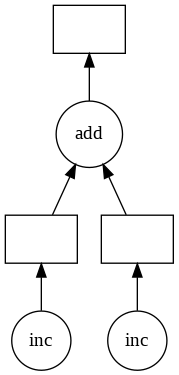

In [ ]:
z.visualize()

In [ ]:
%%time

z.compute()

CPU times: user 79.9 ms, sys: 17 ms, total: 96.9 ms
Wall time: 2 s


5

In [ ]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
%%time

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 318 ms, sys: 31.4 ms, total: 350 ms
Wall time: 8.01 s


In [ ]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

total.compute()

CPU times: user 182 ms, sys: 17.1 ms, total: 199 ms
Wall time: 4.01 s


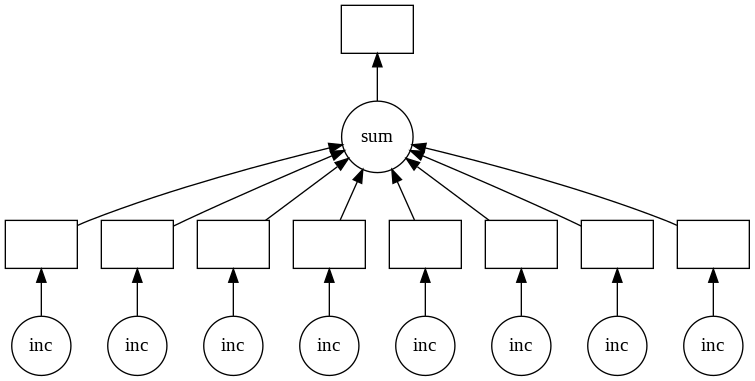

In [ ]:
total.visualize()